<a href="https://colab.research.google.com/github/MoreCookies/scifair23-24/blob/main/FastAI_scifair24_Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from fastai.vision.all import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
import os

from glob import glob

## Download Data

In [3]:
import os
import urllib.request
import zipfile


urls = {
    "train" : "https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Training_Input.zip",
    "train_ground_truth" : "https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Training_GroundTruth.zip",
    "validation" : "https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Validation_Input.zip",
    "validation_ground_truth" : "https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Validation_GroundTruth.zip",
    "test" : "https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Test_Input.zip",
    "test_ground_truth" : "https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Test_GroundTruth.zip",
    #"train_seg": "https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1-2_Training_Input.zip",
    #"train_seg_gt": "https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1_Training_GroundTruth.zip",
    #"validation_seg": "https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1-2_Validation_Input.zip",
    #"validation_seg_gt": "https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1_Validation_GroundTruth.zip",
    "train_2019" : "https://isic-challenge-data.s3.amazonaws.com/2019/ISIC_2019_Training_Input.zip",
    "train_gt_2019" : "https://isic-challenge-data.s3.amazonaws.com/2019/ISIC_2019_Training_GroundTruth.csv"

}

def download_all():
    for item in urls.items():
        name = item[0]
        url = item[1]
        filename = f"{name}.csv"
        if not url.endswith(".csv"):
          filename = f"{name}.zip"
        if os.path.exists(filename):
            print(f"already exists file {filename}")
        else:
            print(f"downloading {filename} from {url} ...")
            urllib.request.urlretrieve(url, filename)
    print(f"done downloading all")

def unzip_all():
    for item in urls.items():
        name = item[0]
        url = item[1]
        filename = f"{name}.zip"
        print(filename)
        if url.endswith(".zip"):
          with zipfile.ZipFile(filename, 'r') as zip_ref:
              print(f"unzipping {filename} to folder")
              zip_ref.extractall(f"{name}")
    print(f"done unzipping all")


if __name__ == "__main__":
    download_all()
    unzip_all()

downloading train.zip from https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Training_Input.zip ...
downloading train_ground_truth.zip from https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Training_GroundTruth.zip ...
downloading validation.zip from https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Validation_Input.zip ...
downloading validation_ground_truth.zip from https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Validation_GroundTruth.zip ...
downloading test.zip from https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Test_Input.zip ...
downloading test_ground_truth.zip from https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Test_GroundTruth.zip ...
downloading train_2019.zip from https://isic-challenge-data.s3.amazonaws.com/2019/ISIC_2019_Training_Input.zip ...
downloading train_gt_2019.csv from https://isic-challenge-data.s3.amazonaws.com/2019/ISIC_2019_Training_GroundTruth.csv ...
done downl

## Data Manipulation

In [4]:
shutil.copy("/content/train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv", "/content/train/ISIC2018_Task3_Training_Input")

'/content/train/ISIC2018_Task3_Training_Input/ISIC2018_Task3_Training_GroundTruth.csv'

In [5]:
def format_csv(df, target=0):
  #add extension
  for i in range(len(df)):
    if ".jpg" not in df["image"].iloc[i]:
      df.at[i, 'image'] = df["image"].iloc[i] + ".jpg"

  #create dx column
  lesion_cols = df.drop("image", axis=1).columns
  if 'dx' in df.columns:
    lesion_cols = df.drop(["image", "dx"], axis=1).columns

  df["dx"] = df[lesion_cols].idxmax(axis=1)
  df = df.fillna(0.0)

  if target != 0:
    df.to_csv(target, index_label=False)
  return df

In [6]:
def get_intersection(df_1, df_2):
  df1 = set(df_1["image"])
  df2 = set(df_2["image"])

  intersection = df1.intersection(df2)
  AnotB = df1.difference(df2)
  BnotA = df2.difference(df1)

  return intersection, AnotB, BnotA

In [7]:
def merge_data(target_path, target_csv, img_paths, csv_paths, target):
  targ_csv = pd.read_csv(target_csv)

  for i in range(len(img_paths)):
    gt = pd.read_csv(csv_paths[i])
    inter = get_intersection(targ_csv, gt)
    #move images
    for x in inter[2]:
      if not x.endswith(".jpg"):
        shutil.copy(os.path.join(img_paths[i], x+".jpg"), os.path.join(target_path, x+".jpg"))
      else:
        shutil.copy(os.path.join(img_paths[i], x+".jpg"), os.path.join(target_path, x+".jpg"))

    #merge datasets
    targ_csv = pd.concat([targ_csv, gt]).drop_duplicates().reset_index(drop=True)

  print("done merge")
  return format_csv(targ_csv, target)


In [8]:
target_path = "/content/train/ISIC2018_Task3_Training_Input"
target_csv = "/content/train/ISIC2018_Task3_Training_Input/ISIC2018_Task3_Training_GroundTruth.csv"

img_paths = ["/content/validation/ISIC2018_Task3_Validation_Input", "/content/train_2019/ISIC_2019_Training_Input"]
csv_paths = ["/content/validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv", "/content/train_gt_2019.csv"]

target = "/content/train/ISIC2018_Task3_Training_Input/Training_GroundTruth_Merged.csv"

gt = merge_data(target_path, target_csv, img_paths, csv_paths, target)

done merge


In [13]:
gt.sample(10)

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC,AK,SCC,UNK,dx
32158,ISIC_0067922.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV
32929,ISIC_0069119.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL
16875,ISIC_0028070.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV
1432,ISIC_0025738.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV
18616,ISIC_0029811.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,SCC
7662,ISIC_0031968.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV
13652,ISIC_0024847.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV
34886,ISIC_0072213.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV
25296,ISIC_0056964.jpg,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BCC
31067,ISIC_0066210.jpg,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BCC


In [47]:
def drop_values(df, value, count=0):
    indexes = df.index[df['dx'] == value].tolist()
    gt = df.copy()

    print(value)
    if count == 0:
      rm_indexes = indexes
    else:
      import random
      rm_indexes = random.sample(indexes, count)
    gt.drop(index=rm_indexes, axis=0, inplace=True)

    if count == 0: gt.drop(labels=value, axis=1, inplace=True)

    return gt


In [48]:
csv_path = "/content/train/ISIC2018_Task3_Training_Input/Training_GroundTruth_Merged.csv"
gt = pd.read_csv(csv_path)


gt_nv_removed = drop_values(gt, "NV", 10000)
gt_nv_removed = gt_nv_removed.drop("UNK", axis=1)
gt_nv_removed = drop_values(gt_nv_removed, "AK")
gt_nv_removed = drop_values(gt_nv_removed, "SCC")

NV
AK
SCC


In [49]:
gt_nv_removed.sample(10)

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC,dx
33136,ISIC_0069422.jpg,0.0,0.0,1.0,0.0,0.0,0.0,0.0,BCC
8392,ISIC_0032698.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL
23056,ISIC_0034251.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV
14578,ISIC_0025773.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV
3742,ISIC_0028048.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV
26609,ISIC_0059062.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV
12970,ISIC_0015544_downsampled.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV
24359,ISIC_0055450.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL
12017,ISIC_0013400_downsampled.jpg,0.0,0.0,0.0,0.0,1.0,0.0,0.0,BKL
12276,ISIC_0013995_downsampled.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL


In [50]:
csv_path = "/content/train/ISIC2018_Task3_Training_Input/Training_GroundTruth_Merged.csv"
gt = pd.read_csv(csv_path)

dls = ImageDataLoaders.from_df(
    gt_nv_removed,
    path="/content/train/ISIC2018_Task3_Training_Input",
    csv_fname=csv_path,
    label_col='dx',
    item_tfms = Resize(460),
    batch_tfms = aug_transforms(size=224, min_scale=0.75),
    bs=64
)


# Get Weights

In [51]:
def get_distribution(df, display=False):
  res = {}
  #values = ['MEL','NV','BCC','AKIEC','BKL','DF','VASC','AK','SCC']
  lesion_cols = df.drop("image", axis=1).columns
  if 'dx' in df.columns:
    lesion_cols = df.drop(["image", "dx"], axis=1).columns
  for i in lesion_cols:
    if not i == "UNK":
      res[i] = df['dx'].value_counts()[i]

  if display == True:
    plt.bar(range(len(res)), list(res.values()), align='center')
    plt.xticks(range(len(res)), list(res.keys()))

    plt.show()
  return res

In [58]:
def get_weights(labels):
    weights_dict = {}
    weights_list = []
    distribution = get_distribution(labels)
    total = sum(distribution.values())
    for i in distribution.keys():
      weight = 1-distribution[i]/total
      weights_dict[i] = weight
      weights_list.append(weight)

    return weights_dict, weights_list


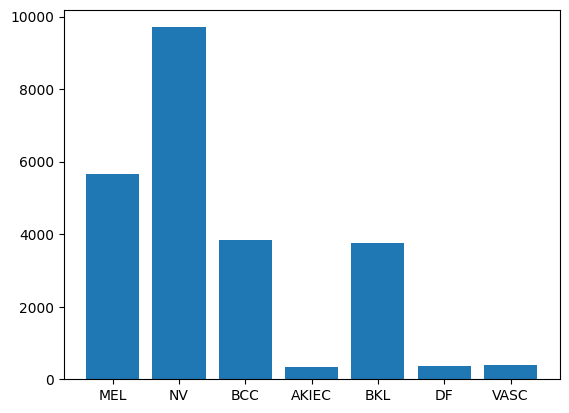

{'MEL': 5656,
 'NV': 9703,
 'BCC': 3852,
 'AKIEC': 335,
 'BKL': 3745,
 'DF': 355,
 'VASC': 398}

In [53]:
get_distribution(gt_nv_removed, True)

In [60]:
weights = get_weights(gt_nv_removed)[1]
weights = torch.FloatTensor(weights)
print(weights)

tensor([0.7648, 0.5964, 0.8398, 0.9861, 0.8442, 0.9852, 0.9834])


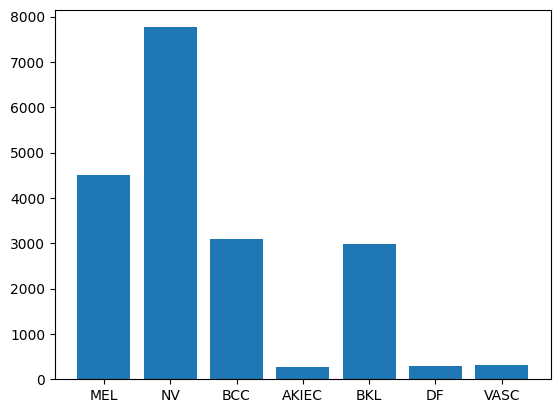

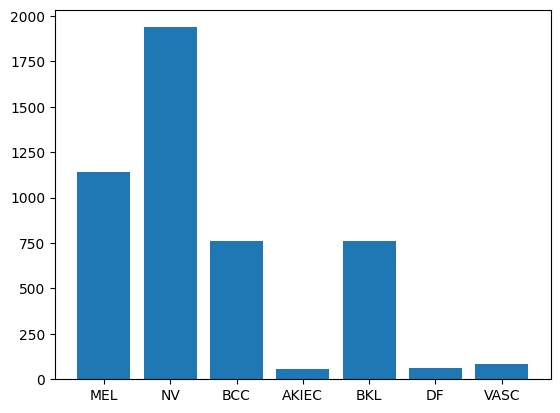

{'MEL': 4517, 'NV': 7765, 'BCC': 3089, 'AKIEC': 279, 'BKL': 2982, 'DF': 291, 'VASC': 313}
{'MEL': 1139, 'NV': 1938, 'BCC': 763, 'AKIEC': 56, 'BKL': 763, 'DF': 64, 'VASC': 85}


In [55]:
train_distribution = get_distribution(dls.train.items, True)
valid_distribution = get_distribution(dls.valid.items, True)
print(train_distribution)
print(valid_distribution)

## Basic Model

In [ ]:
#weights = get_weights(gt) #TODO: convert into pytorch tensor

model = xresnet50()
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(weight=weights), metrics=accuracy, cbs=ShowGraphCallback())
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.194309,1.206962,0.578725,02:39
1,1.085954,1.071913,0.624033,02:37
2,1.027455,1.072655,0.606304,02:40
3,0.947579,1.136471,0.620515,02:39
4,0.917734,0.888091,0.679612,02:40


In [ ]:
# an example of normalization calculated on a batch of images
# (because we aren't using normalization yet, you'll see the mean and standard deviation are not very close to
# 0 and 1 respectively)
x, y = dls.one_batch()

x.mean(dim=[0,2,3]), x.std(dim=[0,2,3])

## dls

In [56]:
def get_dls(batch_size, image_size):
  dls = ImageDataLoaders.from_df(
    gt_nv_removed,
    path="/content/train/ISIC2018_Task3_Training_Input",
    csv_fname="/content/train/ISIC2018_Task3_Training_Input/Training_GroundTruth_Merged.csv",
    valid_pct=0.2,
    label_col='dx',
    item_tfms = Resize(460),
    batch_tfms = [*aug_transforms(size=image_size, min_scale=0.75), Normalize.from_stats(*imagenet_stats)],
    bs=batch_size
  )
  return dls

## Normalization

In [ ]:
dls = get_dls(64, 224)

# an example of normalization calculated on a batch of images
# (because we are using normalization now, the mean and standard deviation are very close to 0 and 1 respectively)
x, y = dls.one_batch()
print(x.mean(dim=[0,2,3]), x.std(dim=[0,2,3]))

# does this normalization improve our model? Let's see ...
model = xresnet50()
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy, cbs=ShowGraphCallback())
learn.fit_one_cycle(5, 3e-3)

## Progressive Resizing

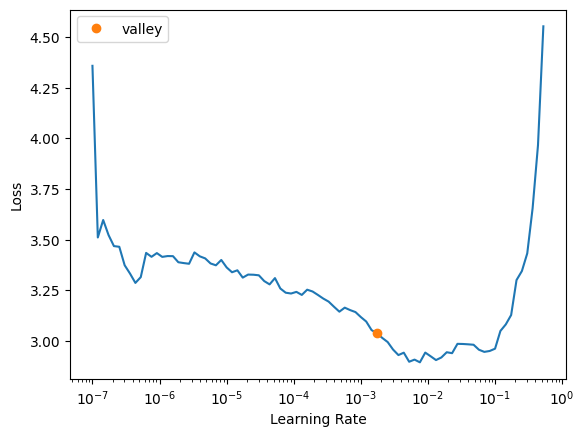

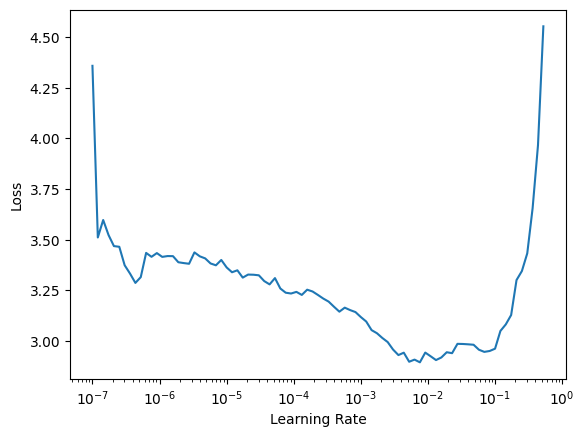

In [61]:
model = densenet121 #experiment with this
dls = get_dls(16,112)
learn = vision_learner(dls, model, loss_func=CrossEntropyLossFlat(weight=weights), metrics=accuracy, cbs=ShowGraphCallback())

learn.lr_find()
learn.recorder.plot_lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,0.895959,0.828795,0.674501,09:51
1,0.789835,0.740585,0.701747,09:39
2,0.705913,0.654920,0.731281,09:42
3,0.664074,0.572544,0.768927,09:56
4,0.605726,0.555599,0.777454,10:13


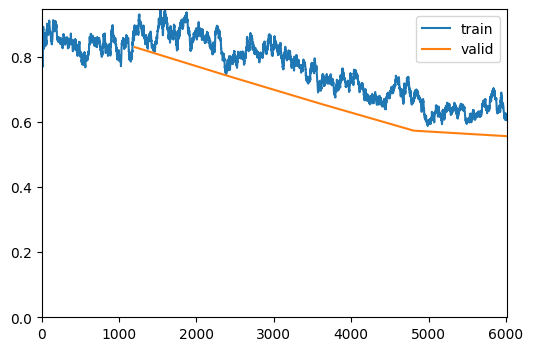

In [63]:
#todo: 192 --> 128 --> 64? --> 32??
#First Train Cycle
learn.fit_one_cycle(5, 2e-3)

In [ ]:
learn.export("/content/models/progressive_resizing_stage1.pkl")

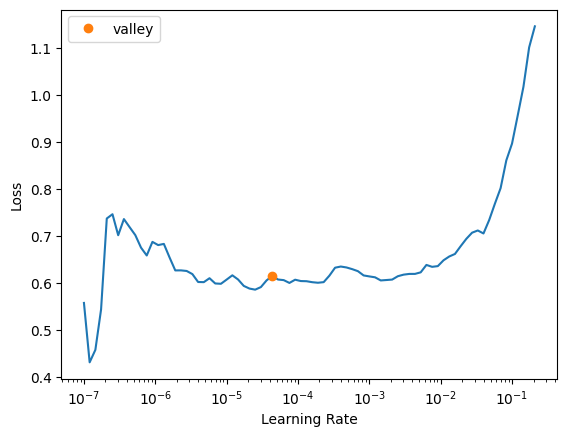

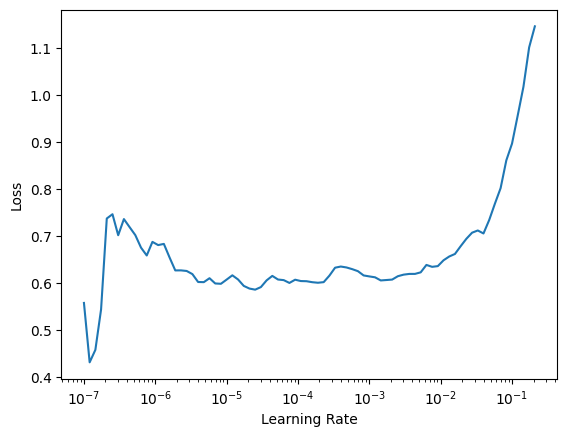

In [64]:
#Resize to 128
learn.dls = get_dls(16, 128)
learn.lr_find()
learn.recorder.plot_lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,0.646307,0.527479,0.784942,10:44
1,0.575357,0.514949,0.791805,10:44
2,0.623410,0.515259,0.790349,10:10
3,0.569028,0.519352,0.786606,10:16
4,0.602342,0.527569,0.782030,10:20


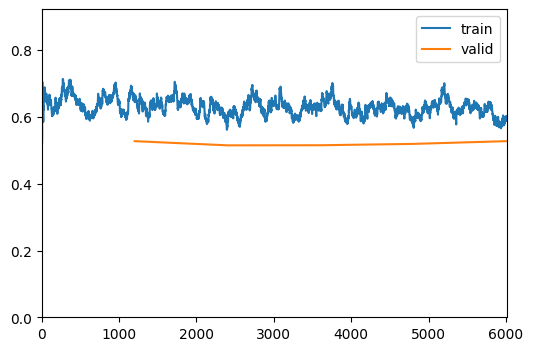

In [65]:
learn.fit_one_cycle(5, 2e-5)

In [67]:
learn.export("/content/models/progressive_resizing_stage2.pkl")

In [75]:
learn.dls = get_dls(16, 224)

In [69]:
learn.lr_find()
learn.recorder.plot_lr_find()

ZeroDivisionError: integer division or modulo by zero

In [70]:
learn.fine_tune(5, 2e-4)

epoch,train_loss,valid_loss,accuracy,time


/usr/local/lib/python3.10/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


ValueError: Exception occured in `ShowGraphCallback` when calling event `after_epoch`:
	max() arg is an empty sequence

In [ ]:
learn.export("/content/models/progressive_resizing_stage3.pkl")

## TTA

In [ ]:
# you can pass any `DataLoaders` to `tta()` (by default it uses your validation `DataLoader`)
preds, targs = learn.tta()
accuracy(preds, targs).item()

## MixUp

In [ ]:
model = xresnet50()
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy, cbs=MixUp)
learn.fit_one_cycle(5, 3e-3)

## Label Smoothing

In [ ]:
model = xresnet50()
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropy(), metrics=accuracy)
learn.fit_one_cycle(5, 3e-3)

## Model Testing

In [77]:
interp = ClassificationInterpretation.from_learner(learn)

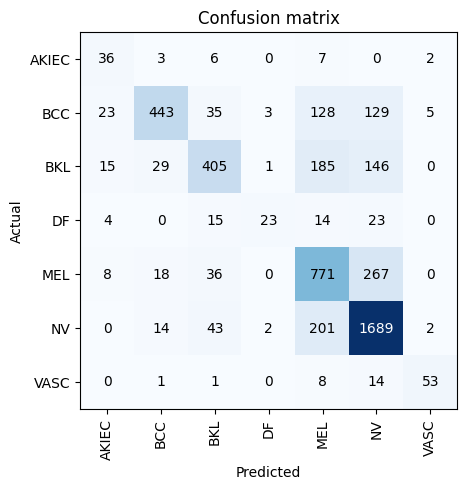

In [78]:
interp.plot_confusion_matrix()

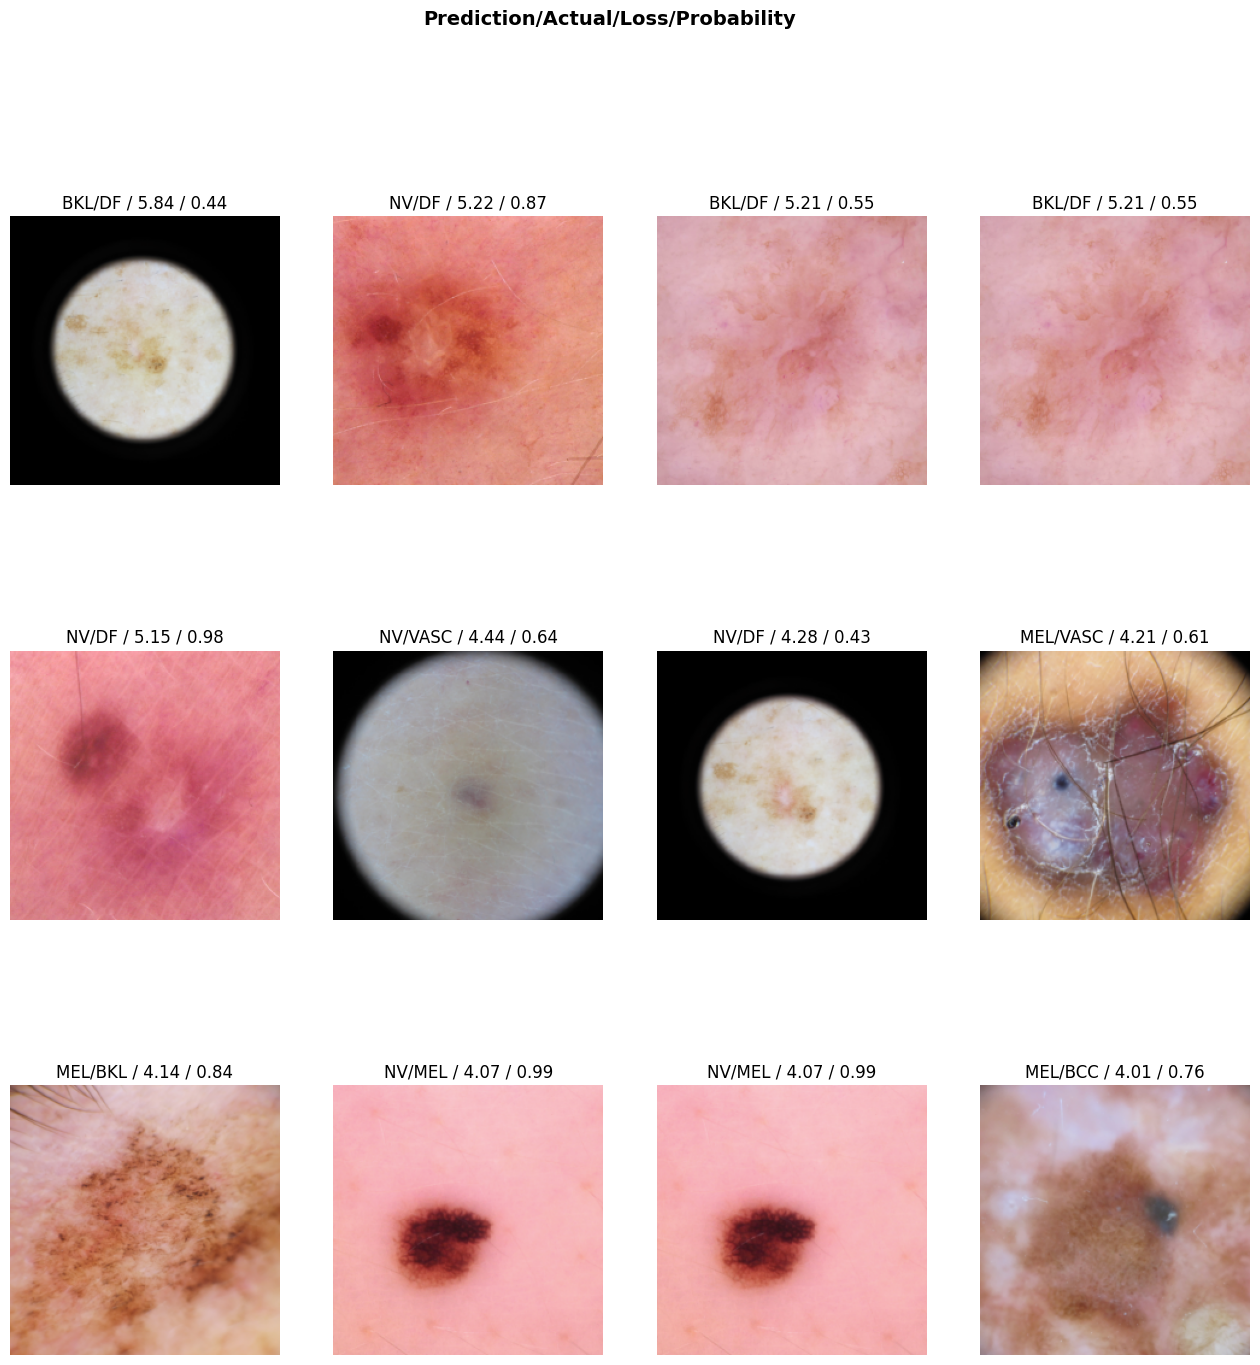

In [79]:
interp.plot_top_losses(12, figsize=(16,16))

In [83]:
# testing using ISIC 2018 test dataset
test_metadata_paths = glob('**/ISIC2018_Task3_Test_GroundTruth.csv', recursive=True)
test_meta_path = test_metadata_paths[0]
test_meta_df = pd.read_csv(test_meta_path, sep=',')
test_meta_df.head()

test_img_paths = glob('./test/**/*.jpg', recursive=True)

dx_dict = { 1.0: "MEL", 2.0:"NV", 4.0:"BCC", 8.0:"AKIEC", 16.0:"BKL", 32.0:"DF", 64.0:"VASC" }
def to_dx(bits_num):
    return dx_dict.get(bits_num)

test_meta_df['bit_fld_num'] = test_meta_df['MEL']*1 + test_meta_df['NV']*2 + test_meta_df['BCC']*4 + test_meta_df['AKIEC']*8 + test_meta_df['BKL']*16 + test_meta_df['DF']*32 + test_meta_df['VASC']*64
test_meta_df['dx'] = test_meta_df['bit_fld_num'].apply(to_dx)

path_dict = {}
for test_img_path in test_img_paths:
    test_img_basename = os.path.basename(test_img_path)
    path_dict[test_img_basename] = test_img_path

def to_path(img_id):
    return path_dict.get(img_id + ".jpg")

test_meta_df['fullpath'] = test_meta_df['image'].apply(to_path)


def to_predict(fullpath):
    result = learn.predict(fullpath)
    return result[0]

test_meta_df['inf'] = test_meta_df['fullpath'].apply(to_predict)

In [84]:
total_cnt = len(test_meta_df)
print(f"total tested = {total_cnt}")
num_not_correct = test_meta_df[test_meta_df['dx'] != test_meta_df['inf']].shape[0]
print(f"number not correctly predicted = {num_not_correct}")
print(f"correctly predicted % = {(total_cnt - num_not_correct)/total_cnt * 100} %")

total tested = 1512
number not correctly predicted = 357
correctly predicted % = 76.38888888888889 %


In [85]:
test_meta_df.to_csv('test_result.csv')